# Dog Breed Prediction 
## Neural Network Classification Project

In [ ]:
# Dataset downloaded from Kaggle
from google.colab import files
files.upload()

In [2]:
# Installing the Kaggle API client.
!pip install -q kaggle

In [3]:
# The Kaggle API client expects this file to be in ~/.kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Creating directory and changing the current working directory
!mkdir dog_dataset
%cd dog_dataset

/content/dog_dataset


In [5]:
# Searching for dataset
!kaggle datasets list -s dogbreedidfromcomp

ref                                title                    size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------  ----------------------  -----  -------------------  -------------  ---------  ---------------  
catherinehorng/dogbreedidfromcomp  dog-breed-id-from-comp  691MB  2020-06-26 03:09:05           2221          6  0.1764706        


In [6]:
# Downloading dataset and coming out of directory
!kaggle datasets download catherinehorng/dogbreedidfromcomp
%cd ..

 97% 672M/691M [00:02<00:00, 287MB/s]
100% 691M/691M [00:02<00:00, 286MB/s]
/content


In [7]:
# Unzipping downloaded file and removing unusable file
!unzip dog_dataset/dogbreedidfromcomp.zip -d dog_dataset
!rm dog_dataset/dogbreedidfromcomp.zip
!rm dog_dataset/sample_submission.csv

Streaming output truncated to the last 5000 lines.
  inflating: dog_dataset/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: dog_dataset/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: dog_dataset/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: dog_dataset/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: dog_dataset/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: dog_dataset/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: dog_dataset/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: dog_dataset/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: dog_dataset/train/83fad0718581a696132c96c166472627.jpg  
  inflating: dog_dataset/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: dog_dataset/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: dog_dataset/train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: dog_dataset/train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: dog_dataset/train/840db91b

## Importing the relevant libraries

In [33]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam
from tqdm import tqdm

In [9]:
# Read the labels.csv file and checking shape and records
labels_all = pd.read_csv("dog_dataset/labels.csv")
print(labels_all.shape)
labels_all.head()

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
breeds_all = labels_all["breed"]
breed_counts = breeds_all.value_counts()
breed_counts.head(60)

In [ ]:
breed_counts.tail(60)

To simplify the model and for limitations in computational power I choose some from the top 10 most popular dog breeds 2022 from https://www.wral.com/trupanion-s-2022-top-10-list-for-dog-breeds-and-dog-names/20581900/

1. Labrador Retriever
2. Golden Retriever
3. French Bulldog
4. German Shepard
5. Shih Tzu
6. Chihuahua
7. Yorkshire Terrier

In [19]:
# Selecting first 3 breeds (Limitation due to computation power)
CLASS_NAMES = ['labrador_retriever','golden_retriever','french_bulldog',
               'german_shepherd', 'shih-tzu', 'chihuahua', 'yorkshire_terrier']
labels = labels_all[(labels_all['breed'].isin(CLASS_NAMES))]
labels = labels.reset_index()
labels.head()

,index,id,breed
0,4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
1,25,00a366d4b4a9bbb6c8a63126697b7656,golden_retriever
2,31,00cc68a50b2d016a6b29af628ea4e04b,labrador_retriever
3,37,0100f55e4f0fe28f2c0465d3fc4b9897,golden_retriever
4,57,0162b3e0144fb1d1ab82fbff3ace9938,shih-tzu


In [22]:
# Creating numpy matrix with zeros
X_data = np.zeros((len(labels), 224, 224, 3), dtype='float32')
# One hot encoding
Y_data = label_binarize(labels['breed'], classes = CLASS_NAMES)

# Reading and converting image to numpy array and normalizing dataset
for i in tqdm(range(len(labels))):
    img = tf.keras.utils.load_img('dog_dataset/train/%s.jpg' % labels['id'][i], target_size=(224, 224))
    img = tf.keras.utils.img_to_array(img)
    x = np.expand_dims(img.copy(), axis=0)
    X_data[i] = x / 255.0
    
# Printing train image and one hot encode shape & size
print('\nTrain Images shape: ',X_data.shape,' size: {:,}'.format(X_data.size))
print('One-hot encoded output shape: ',Y_data.shape,' size: {:,}'.format(Y_data.size))

100%|██████████| 555/555 [00:02<00:00, 190.49it/s]


Train Images shape:  (555, 224, 224, 3)  size: 83,543,040
One-hot encoded output shape:  (555, 7)  size: 3,885


In [43]:
# Splitting the data set into training and testing data sets
X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split(X_data, Y_data, test_size = 0.1)
# Splitting the training data set into training and validation data sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train_and_val, Y_train_and_val, test_size = 0.2)

# Building the NN model

In [53]:
input_size = (224,224,3)
output_size = len(CLASS_NAMES)
    
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5), activation ='relu', input_shape = (input_size)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (5,5), activation ='relu', input_shape = (input_size)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 16, kernel_size = (5,5), activation ='relu', input_shape = (input_size)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(32, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(output_size, activation = "softmax"))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 110, 110, 64)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 106, 106, 32)      51232     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 53, 53, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 49, 49, 16)        12816     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 24, 24, 16)      

In [54]:
# Training the model
epochs = 100
batch_size = 128
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, Y_val), callbacks=[early_stopping])

Epoch 1/100
4/4 [==============================] - 79s 18s/step - loss: 3.5890 - accuracy: 0.1278 - val_loss: 3.2606 - val_accuracy: 0.2100
Epoch 2/100
4/4 [==============================] - 79s 18s/step - loss: 3.1784 - accuracy: 0.1479 - val_loss: 2.9609 - val_accuracy: 0.1200
Epoch 3/100
4/4 [==============================] - 84s 20s/step - loss: 2.8988 - accuracy: 0.1955 - val_loss: 2.7454 - val_accuracy: 0.1300
Epoch 4/100
4/4 [==============================] - 78s 18s/step - loss: 2.6980 - accuracy: 0.1729 - val_loss: 2.5960 - val_accuracy: 0.1200
Epoch 5/100
4/4 [==============================] - 77s 18s/step - loss: 2.5599 - accuracy: 0.1679 - val_loss: 2.5154 - val_accuracy: 0.1300
Epoch 6/100
4/4 [==============================] - 78s 18s/step - loss: 2.4694 - accuracy: 0.2005 - val_loss: 2.4537 - val_accuracy: 0.2500
Epoch 7/100
4/4 [==============================] - 78s 18s/step - loss: 2.4009 - accuracy: 0.2356 - val_loss: 2.4256 - val_accuracy: 0.1200
Epoch 8/100
4/4 [===

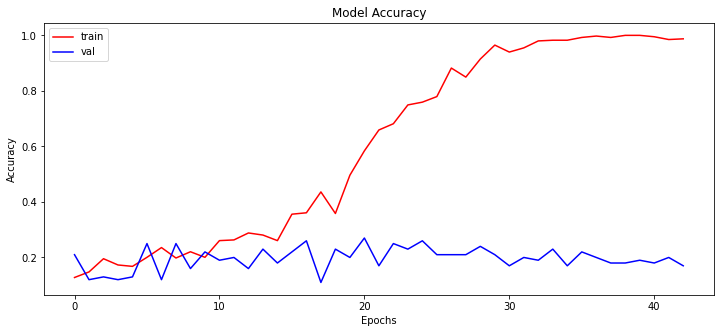

In [55]:
# Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

In [56]:
Y_pred = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')

2/2 [==============================] - 4s 2s/step - loss: 5.2897 - accuracy: 0.1964
Accuracy over the test set: 
  19.64 %


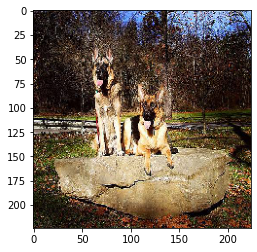

Originally :  golden_retriever
Predicted :  golden_retriever


In [60]:
# Plotting image to compare
plt.imshow(X_test[1,:,:,:])
plt.show()

# Finding max value from predition list and comaparing original value vs predicted
print("Originally : ",labels['breed'][np.argmax(Y_test[1])])
print("Predicted : ",labels['breed'][np.argmax(Y_pred[1])])

In [61]:
model.save("dog_breed.h5")